In [1]:
import torch
#jesus hurtado

In [2]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [3]:
#definicion de la clase2 layers
import torch.nn as nn
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Sequential(         
            nn.Conv2d(
                in_channels=1,              
                out_channels=16,            
                kernel_size=5,              
                stride=1,                   
                padding=2,                  
            ),                              
            nn.ReLU(),                      
            nn.MaxPool2d(kernel_size=2),    
        )
        self.conv2 = nn.Sequential(         
            nn.Conv2d(16, 32, 5, 1, 2),     
            nn.ReLU(),                      
            nn.MaxPool2d(2),                
        )
        # fully connected layer, output 10 classes
        self.out = nn.Linear(32 * 7 * 7, 10)
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        # flatten the output of conv2 to (batch_size, 32 * 7 * 7)
        x = x.view(x.size(0), -1)       
        output = self.out(x)
        return output, x    # return x for visualization

In [5]:
import torchvision.transforms as transforms
#tensores
from torchvision import datasets
from torchvision.transforms import ToTensor
dataset_train = datasets.MNIST(
    root = 'data',
    train = True,                         
    transform = transforms.ToTensor(), 
    download = True,            
)
dataset_test = datasets.MNIST(
    root = 'data', 
    train = False, 
    transform = transforms.ToTensor()
)

In [23]:
#datos
print(dataset_train)
print(dataset_test)


Dataset MNIST
    Number of datapoints: 60000
    Root location: data
    Split: Train
    StandardTransform
Transform: ToTensor()
Dataset MNIST
    Number of datapoints: 10000
    Root location: data
    Split: Test
    StandardTransform
Transform: ToTensor()


In [7]:
#data loaders
from torch.utils.data import DataLoader
train_loader = DataLoader(dataset_train,batch_size=100, shuffle=True)
valid_loader = DataLoader(dataset_test,batch_size=100, shuffle=True)

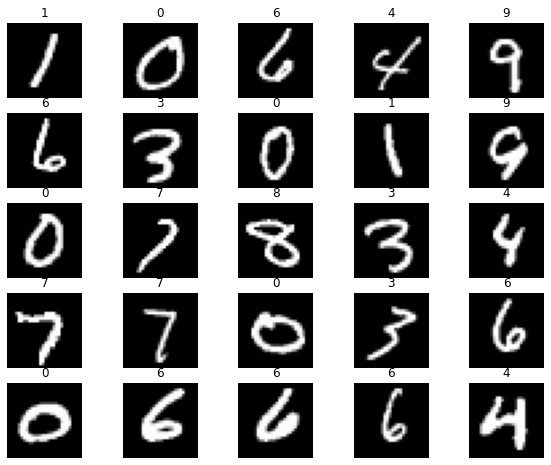

In [8]:
import matplotlib.pyplot as plt

figure = plt.figure(figsize=(10, 8))
cols, rows = 5, 5
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(dataset_train), size=(1,)).item()
    img, label = dataset_train[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(label)
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

In [9]:
#instanciar  el modelo y revisar la configuracion
model = CNN()
print(model)

CNN(
  (conv1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (out): Linear(in_features=1568, out_features=10, bias=True)
)


In [10]:
#parametros del sistema
num_workers=0
batch_size=100
valid_size=0.2


In [11]:
#instancia gpu
use_cuda=True
if use_cuda and torch.cuda.is_available():

    model.cuda()
print(model,'\n',' GPU Activa: ',use_cuda and torch.cuda.is_available())

CNN(
  (conv1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (out): Linear(in_features=1568, out_features=10, bias=True)
) 
  GPU Activa:  False


In [12]:
from torch.utils.data import DataLoader
loaders = {
    'train' : torch.utils.data.DataLoader(dataset_train, 
                                          batch_size=100, 
                                          shuffle=True, 
                                          num_workers=1),
    
    'test'  : torch.utils.data.DataLoader(dataset_test, 
                                          batch_size=100, 
                                          shuffle=True, 
                                          num_workers=1),
}
loaders

{'test': <torch.utils.data.dataloader.DataLoader at 0x7fd2d8fdc350>,
 'train': <torch.utils.data.dataloader.DataLoader at 0x7fd39420a310>}

In [13]:
loss_func = nn.CrossEntropyLoss()   
loss_func

CrossEntropyLoss()

In [14]:
import torch.nn as nn
from torch.autograd import Variable

In [15]:
from torch import optim
#optimizador
optimizer = optim.Adam(model.parameters(), lr = 0.01)   
optimizer

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.01
    maximize: False
    weight_decay: 0
)

In [16]:
#Entrenamiento de la red calculo de lost y acc
run = 0
num_epochs = 10
input_size = 28*28  #Size of image
total_step = len(loaders['test'])    
num_classes = 10  #the image number are in range 0-10
model.train()
for epoch in range(num_epochs):
    for i,(images,labels) in  enumerate(loaders['train']):
#       images = torch.autograd.Variable(images.view(-1,input_size))
#        labels = torch.autograd.Variable(labels)
        
        # Nullify gradients w.r.t. parameters
        optimizer.zero_grad()
        #forward propagation
        b_x = Variable(images)   # batch x
        b_y = Variable(labels)   # batch y
        output = model(b_x)[0]                
        loss = loss_func(output, b_y)
        # backward propagation
        loss.backward()
        # update the parameters
        optimizer.step()
        run+=1
        
        if (i+1)%200 == 0:
            # check total accuracy of predicted value and actual label
            accurate = 0
            total = 0
            for i, (images1, labels1) in enumerate(loaders['test']):
  #                images = torch.autograd.Variable(images.view(-1,input_size))
                b_x = Variable(images1)   # batch x                 
                b_y = Variable(labels1)   # batch y
                output = model(b_x)[0]                       
                _,predicted = torch.max(output.data, 1)
                # total labels
                total+= labels.size(0)
                
                # Total correct predictions
                accurate+= (predicted == labels).sum()
                accuracy_score = 10 * accurate/total
            
            print('Iteration: {}. Loss: {}. Accuracy: {}'.format(run, loss.item(), accuracy_score))

print('Final Accuracy:',accuracy_score)


 

Iteration: 200. Loss: 0.1070561408996582. Accuracy: 0.9929999709129333
Iteration: 400. Loss: 0.037786632776260376. Accuracy: 0.9589999914169312
Iteration: 600. Loss: 0.04493246600031853. Accuracy: 0.9430000185966492
Iteration: 800. Loss: 0.04369038715958595. Accuracy: 1.0429999828338623
Iteration: 1000. Loss: 0.03020661324262619. Accuracy: 0.9319999814033508
Iteration: 1200. Loss: 0.05444283410906792. Accuracy: 0.9980000257492065
Iteration: 1400. Loss: 0.05777895450592041. Accuracy: 0.9909999966621399
Iteration: 1600. Loss: 0.09116599708795547. Accuracy: 1.0119999647140503
Iteration: 1800. Loss: 0.05686502158641815. Accuracy: 0.9909999966621399
Iteration: 2000. Loss: 0.050729312002658844. Accuracy: 1.0329999923706055
Iteration: 2200. Loss: 0.01607321947813034. Accuracy: 1.003000020980835
Iteration: 2400. Loss: 0.020398886874318123. Accuracy: 1.0609999895095825
Iteration: 2600. Loss: 0.02992585115134716. Accuracy: 0.9620000123977661
Iteration: 2800. Loss: 0.00843649823218584. Accuracy: 

In [22]:
import math
test_acc = loss.item()

n_layers  = 2 # (conv + activacion + pooling = 1 capa)
n_epochs = 10 
nparameters = 2 

score = test_acc / math.log(nparameters)  * 10 /  n_epochs * test_acc * n_layers

In [19]:
print(' Score resultante ' , score)

 Score resultante  0.15573546432231458
